In [25]:
# Written by Varun Hiremath
# Flame AI challenge 

In [26]:
import numpy as np                                                                                                                                                                                                                                                                        
import matplotlib.pyplot as plt                                                                                                                                                                                                                                                           
import seaborn as sns                                                                                                                                                                                                                                                                    
import pandas as pd
import os, shutil                                                                                                                                                                                                                                                                                         
import tensorflow as tf

In [27]:
input_path = '/kaggle/input/2023-flame-ai-challenge/dataset/'
output_path = '/kaggle/working/'

FILES = {}                                                                                                                                                                                                                                                                                
FILES["train"] = pd.read_csv(input_path+'train.csv').reset_index()                                                                                                                                                                                                                        
FILES["val"]   = pd.read_csv(input_path+'val.csv').reset_index()
FILES["test"]  = pd.read_csv(input_path+'test.csv').reset_index()    

RES_SIZE = {}
RES_SIZE["LR"] = 16
RES_SIZE["HR"] = 128

my_mean = np.array([0.24,28.0, 28.0, 28.0])
my_std = np.array([0.068,48.0, 48.0, 48.0])

In [28]:
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

In [29]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# Residual Block
def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x

# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x

def make_model(num_filters=64, num_of_residual_blocks=16):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 4))
    
    # Scaling Pixel Values
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(input_layer)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    output_layer = layers.Conv2D(4, 3, padding="same")(x)

    return Model(input_layer, output_layer)

In [30]:
model = make_model()

In [31]:
# get data in tensor flow format for given resolution and mode (train/val/test)
def get_data_in_tf(res, mode, idx):    
    data_path = input_path+"flowfields/%s/%s" % (res, mode)                                                                                                                                                                                                                               
    file_df = FILES[mode]
    file_df.head()    
    fid = file_df['id'][idx]
    
    RHO_filename = file_df['rho_filename'][idx]                                                                                                                                                                                                                                           
    UX_filename = file_df['ux_filename'][idx]                                                                                                                                                                                                                                             
    UY_filename = file_df['uy_filename'][idx]                                                                                                                                                                                                                                             
    UZ_filename = file_df['uz_filename'][idx]
    
    size = RES_SIZE[res]
    RHO = np.fromfile(data_path + "/" + RHO_filename, dtype="<f4").reshape(size,size)                                                                                                                                                                                                                     
    UX = np.fromfile(data_path + "/" + UX_filename, dtype="<f4").reshape(size,size)                                                                                                                                                                                                                          
    UY = np.fromfile(data_path + "/" + UY_filename, dtype="<f4").reshape(size,size)                                                                                                                                                                                                                          
    UZ = np.fromfile(data_path + "/" + UZ_filename, dtype="<f4").reshape(size,size)
   
    X = tf.stack([RHO,UX,UY,UZ],axis=2)
    X = (X-my_mean)/my_std
    return fid,X

# predict solution using given model for one input in specified mode (train/val/test)
def predict(model, mode, idx):
    fid,X = get_data_in_tf("LR", mode, idx)    
    X = tf.expand_dims(X,0)
    y_pred = model.predict(X,verbose=0)
    return fid,y_pred

In [32]:
def getXY(mode, idx):
    fid,X = get_data_in_tf("LR",mode, idx)
    fid,Y = get_data_in_tf("HR",mode, idx)
    return [X,Y]

def getTrainXY(idx):
    return getXY("train", int(idx))

def getValXY(idx):
    return getXY("val", int(idx))

In [33]:
def load_train_dataset_wrapper(fid):
    return tf.py_function(getTrainXY, inp=[fid], Tout=[tf.float32,tf.float32])

def load_val_dataset_wrapper(fid):
    return tf.py_function(getValXY, inp=[fid], Tout=[tf.float32,tf.float32])

In [34]:
batch_size = 32

ntrain = len(FILES["train"])
train_ds = tf.data.Dataset.from_tensor_slices(range(ntrain))
train_ds = (train_ds
    .shuffle(ntrain)
    .map(load_train_dataset_wrapper, num_parallel_calls=tf.data.AUTOTUNE)    
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

nval = len(FILES["val"])
val_ds = tf.data.Dataset.from_tensor_slices(range(nval))
val_ds = (val_ds
    .map(load_val_dataset_wrapper, num_parallel_calls=tf.data.AUTOTUNE)    
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [35]:
#create directories for checkpoints and logs
log_dir = output_path + "logs" 
checkpoint_dir = output_path + "ckpt-gpu"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

def load_model(nckpt):    
    checkpoint_path = checkpoint_dir + "/ckpt-" + str(nckpt).zfill(3)
    restored_model =  tf.keras.models.load_model(checkpoint_path)
    model.set_weights(restored_model.get_weights())
    print("Restoring from", checkpoint_path)
    return model

# Either restore the latest model, or create a fresh one if there is no checkpoint available.
def make_or_restore_model(alpha=1e-3, nckpt=0, restore=True):    
    #set up save/load checkpoints
    model = make_model()
    if restore and (nckpt > 0):
        checkpoint_path = checkpoint_dir + "/ckpt-" + str(nckpt).zfill(3)
        restored_model =  tf.keras.models.load_model(checkpoint_path)
        model.set_weights(restored_model.get_weights())
        print("Restoring from", checkpoint_path)        
    else:        
        print("Creating a new model")  
    
    #compile model with optimizerloss functions,metrics    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=alpha),
                  loss=tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size'),
                  metrics =[tf.keras.metrics.MeanAbsoluteError()]) #add other metrics here

    return [model,nckpt]

In [36]:
def run_training(train_dataset=train_ds,val_dataset=val_ds,nckpt=100,epochs=100,fresh=False):
    # Create a MirroredStrategy for multi-gpu
    strategy = tf.distribute.MirroredStrategy()
    print('Number of GPUs: {}'.format(strategy.num_replicas_in_sync))
    if fresh:
        shutil.rmtree(checkpoint_dir)
        os.makedirs(checkpoint_dir)
        
    # reduce alpha progressively
    alpha = 1e-3
    if (nckpt >= 100):
        alpha = 5e-4    
    if (nckpt >= 200):
        alpha = 1e-4
    if (nckpt >= 300):
        alpha = 1e-5
        
    # For multi-gpu: Open a strategy scope and create/restore the model
    with strategy.scope():
        [model,nckpt] = make_or_restore_model(alpha=alpha,nckpt=nckpt,restore=(not fresh))
    #set up checkpoints and logs
    callbacks = [
        # This callback saves a SavedModel every epoch
        tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_dir + "/ckpt-{epoch:03d}", save_freq="epoch"
        ),
        # This callback logs every epoch
        tf.keras.callbacks.CSVLogger(log_dir + "/model_history_log.csv", append=True)
    ]
    
    #train
    model.fit(
        train_dataset,
        epochs=epochs,        
        initial_epoch=nckpt,
        callbacks=callbacks,
        verbose=1,
        validation_data = val_dataset
    )
    
    #save at the end of epoch
    model.save(output_path+'final_model')

In [37]:
nckpt = 0 #last stable checkpoint to start from
nepochs = 100 #last epoch to run
run_training(nckpt=nckpt,epochs=nepochs,fresh=False)

Number of GPUs: 2
Creating a new model
Epoch 1/100
44/44 [==============================] - 61s 790ms/step - loss: 1.7767 - mean_absolute_error: 0.6720 - val_loss: 0.1778 - val_mean_absolute_error: 0.2939
Epoch 2/100
44/44 [==============================] - 32s 742ms/step - loss: 0.1588 - mean_absolute_error: 0.2740 - val_loss: 0.1384 - val_mean_absolute_error: 0.2527
Epoch 3/100
44/44 [==============================] - 35s 810ms/step - loss: 0.1146 - mean_absolute_error: 0.2237 - val_loss: 0.0969 - val_mean_absolute_error: 0.2042
Epoch 4/100
44/44 [==============================] - 33s 752ms/step - loss: 0.0923 - mean_absolute_error: 0.1985 - val_loss: 0.0720 - val_mean_absolute_error: 0.1710
Epoch 5/100
44/44 [==============================] - 32s 733ms/step - loss: 0.0696 - mean_absolute_error: 0.1711 - val_loss: 0.0557 - val_mean_absolute_error: 0.1525
Epoch 6/100
44/44 [==============================] - 33s 763ms/step - loss: 0.0553 - mean_absolute_error: 0.1523 - val_loss: 0.0478

In [38]:
nckpt = 100 #last stable checkpoint to start from
nepochs = 200 #last epoch to run
run_training(nckpt=nckpt,epochs=nepochs,fresh=False)

Number of GPUs: 2
Restoring from /kaggle/working/ckpt-gpu/ckpt-100
Epoch 101/200
44/44 [==============================] - 60s 784ms/step - loss: 0.0404 - mean_absolute_error: 0.1247 - val_loss: 0.0173 - val_mean_absolute_error: 0.0880
Epoch 102/200
44/44 [==============================] - 36s 823ms/step - loss: 0.0119 - mean_absolute_error: 0.0662 - val_loss: 0.0106 - val_mean_absolute_error: 0.0609
Epoch 103/200
44/44 [==============================] - 33s 747ms/step - loss: 0.0106 - mean_absolute_error: 0.0617 - val_loss: 0.0105 - val_mean_absolute_error: 0.0618
Epoch 104/200
44/44 [==============================] - 31s 714ms/step - loss: 0.0092 - mean_absolute_error: 0.0547 - val_loss: 0.0100 - val_mean_absolute_error: 0.0562
Epoch 105/200
44/44 [==============================] - 34s 768ms/step - loss: 0.0105 - mean_absolute_error: 0.0625 - val_loss: 0.0100 - val_mean_absolute_error: 0.0574
Epoch 106/200
44/44 [==============================] - 31s 719ms/step - loss: 0.0084 - mean_a

In [39]:
nepochs = 194 # picking one with minimum val_loss
model = load_model(nckpt=nepochs)

Restoring from /kaggle/working/ckpt-gpu/ckpt-194


In [40]:
def plot_data(model, mode, idx):    
    fid,x0_real = get_data_in_tf("LR", mode, idx)
    if (mode != "test"): #no HR data available for test mode
        fid,y0_real = get_data_in_tf("HR", mode, idx)
    fid,y0_pred = predict(model, mode, idx)
    
    rows = 2 if (mode == "test") else 3
    fig, axs = plt.subplots(rows, 4, figsize=(20, 5*rows))
    fig.suptitle("Comparison of %s data at id = %d with file id = %d" %(mode, idx, fid), fontsize=16)
    
    VARS = ["RHO", "UX", "UY", "UZ"]
    for i in range(4):
        axs[0,i].imshow(x0_real[:,:,i], cmap='jet')
        axs[0,i].set_title('LR Data 16x16: %s' % VARS[i])
        
        axs[1,i].imshow(y0_pred[0][:,:,i], cmap='jet')
        axs[1,i].set_title('Prediction 128x128: %s' % VARS[i])
        
        if (mode != "test"):
            axs[2,i].imshow(y0_real[:,:,i], cmap='jet')
            axs[2,i].set_title('HR Data 128x128: %s' % VARS[i])
        

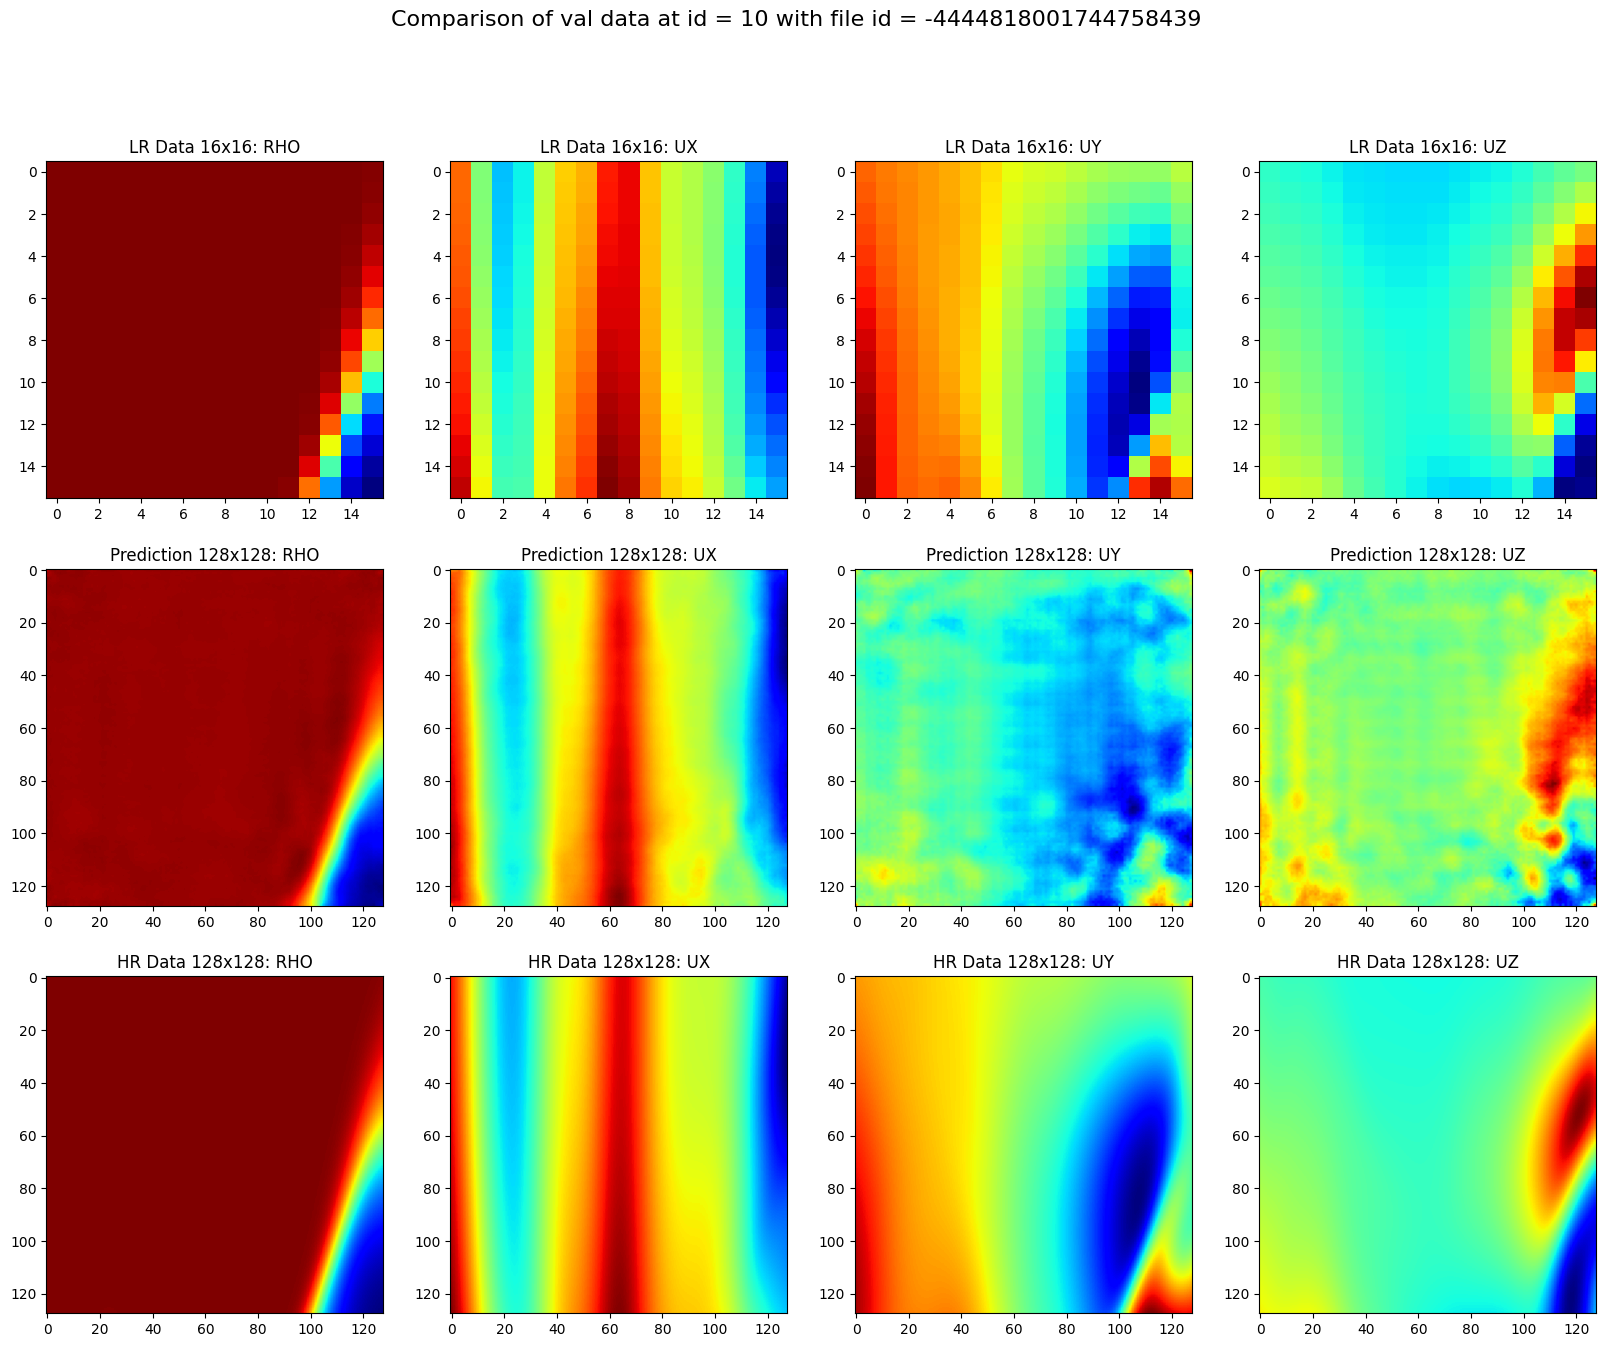

In [41]:
plot_data(model, "val", 10)

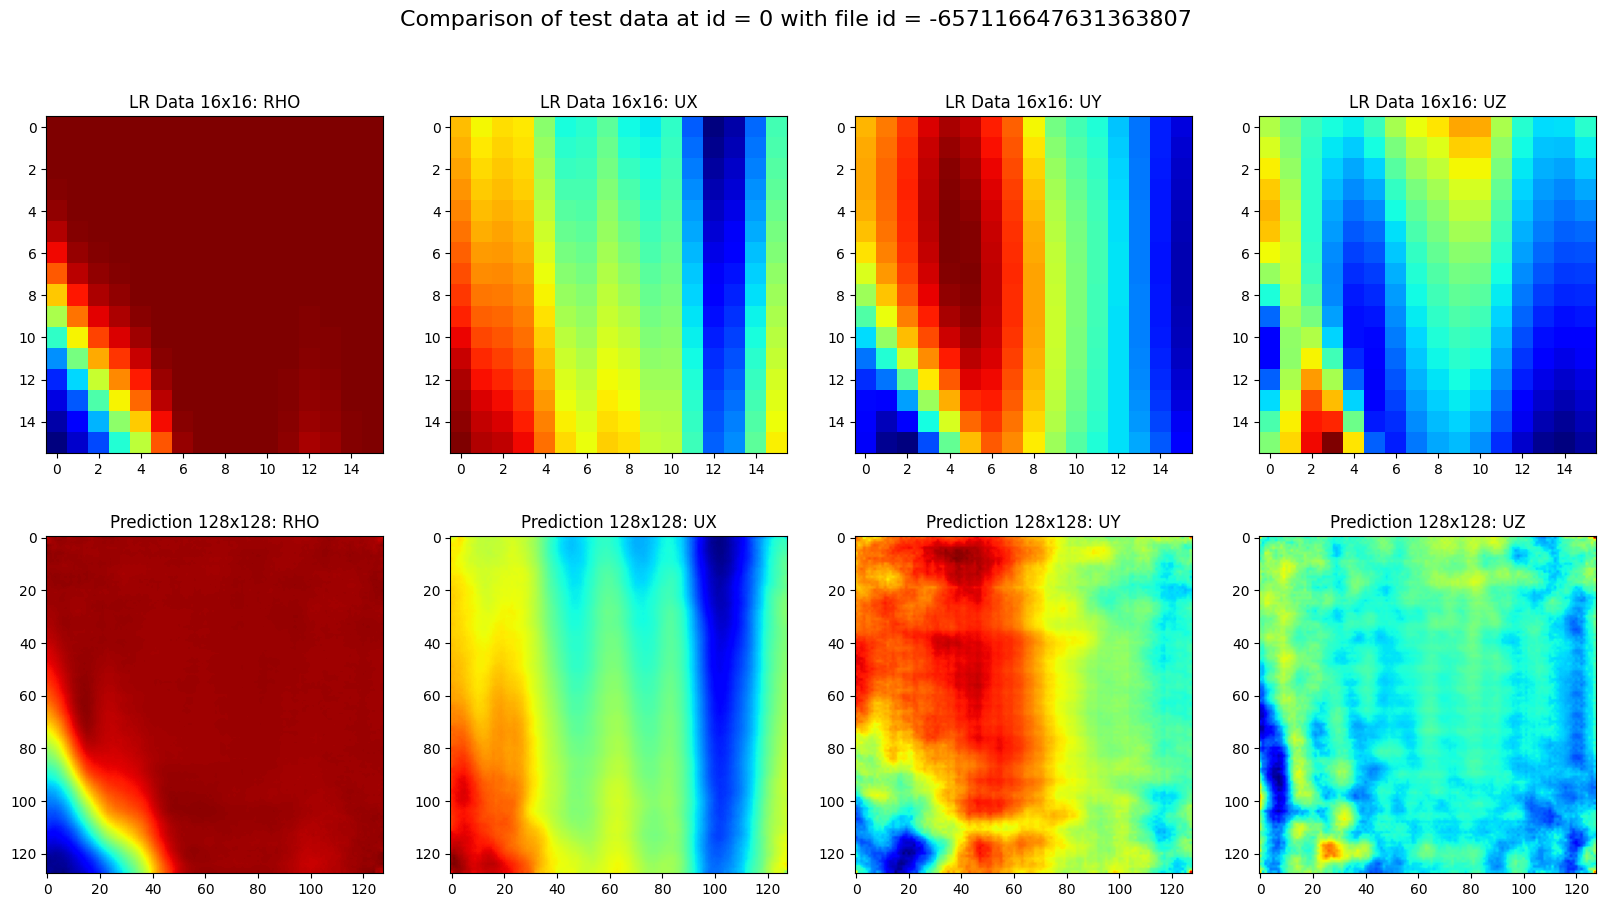

In [42]:
plot_data(model, "test", 0)

In [43]:
# generates solutions using given model for the specified mode of data
def generate_solutions(model, mode):
    y_preds = {}
    ids = []
    for idx in range(len(FILES[mode])):
        fid,y_pred = predict(model, mode, idx) 
        ids.append(fid)
        y_preds[fid] = np.array(y_pred).flatten(order='C').astype(np.float32)
        
    df = pd.DataFrame.from_dict(y_preds,orient='index')
    df['id'] = ids
    #move id to first column
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    #reset index
    df = df.reset_index(drop=True)

    return df

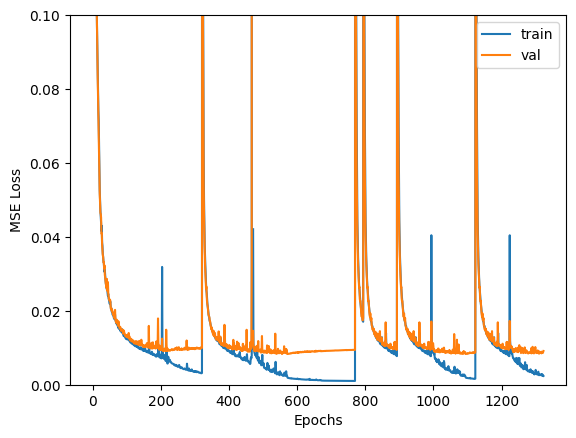

In [44]:
metrics = pd.read_csv(output_path+'logs/model_history_log.csv')
plt.plot(metrics['loss'],label='train')
plt.plot(metrics['val_loss'],label='val')
plt.ylim([0,0.1])
plt.ylabel("MSE Loss")
plt.xlabel("Epochs")
plt.legend()

In [45]:
# generate solutions for the test data
df = generate_solutions(model, "test")
df.head()

,id,0,1,2,3,4,5,6,7,8,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,-657116647631363807,0.900947,0.895865,-0.518125,-0.537144,0.955090,0.910451,-0.535643,-0.573092,0.969227,...,-0.607304,-0.578461,0.958637,0.910567,-0.579919,-0.569116,0.914877,0.825056,-0.503473,-0.525927
1,7483162365939134796,0.881816,0.694000,-0.550735,-0.560825,0.933697,0.718081,-0.567731,-0.602867,0.941621,...,-0.364404,-0.565268,0.920806,0.344509,-0.334620,-0.566689,0.888503,0.275426,-0.267157,-0.508266
2,-6212758420087317096,0.905725,0.618007,-0.543855,-0.533653,0.959718,0.628892,-0.565846,-0.572134,0.968859,...,-0.566652,-0.560346,0.936409,0.843485,-0.544637,-0.552621,0.895276,0.753853,-0.475692,-0.509616
3,-1825935182480952214,-0.799308,1.167037,-0.255121,-0.848255,-0.872697,1.184515,-0.240658,-0.941691,-0.861399,...,-0.739226,-1.286641,-0.790025,1.651091,-0.758047,-1.210491,-0.759856,1.617091,-0.691967,-1.117901
4,-1859240836295259171,2.340809,-0.507168,-0.511913,-0.499868,2.479112,-0.536669,-0.524052,-0.562989,2.470410,...,-0.270060,-0.728083,1.029521,-0.296067,-0.267261,-0.704201,0.983364,-0.369615,-0.215184,-0.610110


In [46]:
# generate the output file for submission
df.to_csv(output_path+'tf_model_solution_at_epochs_%d.csv' % nepochs, index=False)